# Globals

In [56]:
from Models import TransformerBase, BufferEmbedding, BufferEncoding
from Models.util.qol import manage_params
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time as clock
from torch import Tensor
from torch.nn import Module
from torch.optim import lr_scheduler
from copy import deepcopy

%matplotlib inline

In [57]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.bfloat16

# Data creation

In [58]:
MULTIPLIER = 0.01

In [59]:
def create_data(records: int, limits: tuple[int, int], seq_len: int, min_len: int | None = None,
                step: int | None = None, offset: int | None = None,
                device: torch.device = 'cpu', dtype: torch.dtype = torch.float32):
    limit_range = limits[1] - limits[0]
    assert limit_range > (seq_len * 2 // step) + offset
    if min_len is None:
        min_len = seq_len
    assert min_len > 0
    if step is None:
        step = 1
    if offset is None:
        offset = 0

    inputs = torch.stack([
        torch.cat([
            torch.arange(start, start + seq_len - padding, step, device=device, dtype=torch.float),
            torch.full((padding,), -1, device=device, dtype=torch.float),
        ])
        for start, padding in zip(
            np.random.randint(limits[0], limits[0] + limit_range // 3, records),
            np.random.randint(0, seq_len - min_len + 1, records)
        )
    ])
    try:
        outputs = torch.stack([
            torch.arange(start, start + seq_len, step, device=device, dtype=torch.float)
            for start in [
                inp[inp != -1].min().cpu().item() + 1 + offset
                for inp in inputs
            ]
            # for start in (torch.max(inputs, -1,)[0] + 1)
        ])
    except Exception as e:
        print(inputs[:3, [0, 1, -2, -1]])
        raise e

    return tuple([(t * MULTIPLIER).to(dtype) for t in [inputs, outputs]])

In [220]:
RECORDS = 2000
LIMITS = (0, 400)
MAX_SEQ_LEN = 256
SEQ_LEN = 100
MIN_LEN = SEQ_LEN - 30
STEP = 1
OFFSET = 5

In [221]:
train_inp, train_out = create_data(RECORDS, LIMITS, SEQ_LEN, MIN_LEN, STEP, OFFSET, DEVICE, DTYPE)
eval_inp, eval_out = create_data(RECORDS // 10, LIMITS, SEQ_LEN, MIN_LEN, STEP, OFFSET, DEVICE, DTYPE)
train_inp.shape, train_out.shape, eval_inp.shape, eval_out.shape

(torch.Size([2000, 100]),
 torch.Size([2000, 100]),
 torch.Size([200, 100]),
 torch.Size([200, 100]))

In [222]:
def sample_batch(*tensors: Tensor, n: int) -> tuple[Tensor, ...]:
    """
    Randomly sample n unique indices from the first dimension of a tensor.

    Args:
        tensor (torch.Tensor): Input tensor of shape (batch_size, ...).
        n (int): Number of samples to draw.

    Returns:
        torch.Tensor: Tensor subset with n unique rows.
    """
    assert len(tensors) > 0
    assert tensors[0].size(0) > 0
    batch_size = tensors[0].size(0)
    indices = torch.randperm(batch_size)[:n]  # unique, random order
    return tuple([t[indices] for t in tensors])

In [223]:
test_inp, test_out = sample_batch(eval_inp, eval_out, n=3)

In [224]:
torch.round(test_inp[:, -10].to(torch.float64) / MULTIPLIER)

tensor([-1., -1., -1.], device='cuda:0', dtype=torch.float64)

In [225]:
torch.round(test_out[:, :10].to(torch.float64) / MULTIPLIER)

tensor([[26., 27., 28., 29., 30., 31., 32., 33., 34., 35.],
        [89., 90., 91., 92., 93., 94., 95., 96., 97., 98.],
        [75., 76., 77., 78., 79., 80., 81., 82., 83., 84.]], device='cuda:0',
       dtype=torch.float64)

In [226]:
class Dictionary(Module):
    def __init__(self, limits: tuple[int, int], padding_value: int, multiplier = 0.01):
        super(Dictionary, self).__init__()
        self.point = abs(round(math.log10(multiplier)))
        self.mapping = {round(value * multiplier, self.point): index for index, value in enumerate(range(*limits))}
        self.mapping[round(padding_value * multiplier, self.point)] = max(list(self.mapping.values()))+1
        self.reverse = {value: key for key, value in self.mapping.items()}
        self.vocab_size = max(list(self.mapping.values()))+1

    def forward(self, tensor: Tensor):
        tensor = tensor.clone()
        for key in tensor.unique(False).tolist():
            key = round(key, self.point)
            tensor[tensor == key] = self.mapping[key]
        return tensor

In [227]:
dictionary = Dictionary(LIMITS, -1, MULTIPLIER)
VOCAB_SIZE = dictionary.vocab_size
VOCAB_SIZE

401

In [228]:
dictionary.mapping

{0.0: 0,
 0.01: 1,
 0.02: 2,
 0.03: 3,
 0.04: 4,
 0.05: 5,
 0.06: 6,
 0.07: 7,
 0.08: 8,
 0.09: 9,
 0.1: 10,
 0.11: 11,
 0.12: 12,
 0.13: 13,
 0.14: 14,
 0.15: 15,
 0.16: 16,
 0.17: 17,
 0.18: 18,
 0.19: 19,
 0.2: 20,
 0.21: 21,
 0.22: 22,
 0.23: 23,
 0.24: 24,
 0.25: 25,
 0.26: 26,
 0.27: 27,
 0.28: 28,
 0.29: 29,
 0.3: 30,
 0.31: 31,
 0.32: 32,
 0.33: 33,
 0.34: 34,
 0.35: 35,
 0.36: 36,
 0.37: 37,
 0.38: 38,
 0.39: 39,
 0.4: 40,
 0.41: 41,
 0.42: 42,
 0.43: 43,
 0.44: 44,
 0.45: 45,
 0.46: 46,
 0.47: 47,
 0.48: 48,
 0.49: 49,
 0.5: 50,
 0.51: 51,
 0.52: 52,
 0.53: 53,
 0.54: 54,
 0.55: 55,
 0.56: 56,
 0.57: 57,
 0.58: 58,
 0.59: 59,
 0.6: 60,
 0.61: 61,
 0.62: 62,
 0.63: 63,
 0.64: 64,
 0.65: 65,
 0.66: 66,
 0.67: 67,
 0.68: 68,
 0.69: 69,
 0.7: 70,
 0.71: 71,
 0.72: 72,
 0.73: 73,
 0.74: 74,
 0.75: 75,
 0.76: 76,
 0.77: 77,
 0.78: 78,
 0.79: 79,
 0.8: 80,
 0.81: 81,
 0.82: 82,
 0.83: 83,
 0.84: 84,
 0.85: 85,
 0.86: 86,
 0.87: 87,
 0.88: 88,
 0.89: 89,
 0.9: 90,
 0.91: 91,
 0.92: 9

In [229]:
torch.round(test_inp.to(torch.float64) / MULTIPLIER)

tensor([[ 20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
          32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
          44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
          56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
          68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
          80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,
          92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
         104., 105., 106., 107.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ 83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
          95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
         107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
         119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 

In [230]:
torch.round(dictionary(test_inp).to(torch.float64))

tensor([[ 20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
          32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
          44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
          56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
          68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
          80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,
          92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
         104., 105., 106., 107., 400., 400., 400., 400., 400., 400., 400., 400.,
         400., 400., 400., 400.],
        [ 83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
          95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
         107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
         119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 

# Design model

In [231]:
class Transformer(Module):
    def __init__(self, features: int, max_seq_len: int, embed_size: int, layers: int, heads: int, bias: bool = False,
                 device: torch.device = 'cpu', dtype: torch.dtype = torch.float32, **options):
        super(Transformer, self).__init__()

        # Attributes
        self.max_seq_len = max_seq_len
        self.embed_size = embed_size
        self.heads = heads
        self.device = device
        self.dtype = dtype
        self.type = manage_params(options, 'type', 'continuous')
        self.differential: int | None = manage_params(options, 'differential', False)
        self.epsilon: float | None = manage_params(options, 'epsilon', 1e-9)
        self.probabilistic: bool = manage_params(options, 'probabilistic', False)

        # Build
        self.embedder = BufferEmbedding(1 if self.type == 'continuous' else features, embed_size, True, self.type,
                                        device, dtype, padding_idx=manage_params(options, 'padding_idx', None))
        # self.encoder = BufferEncoding(max_seq_len, embed_size, True, 'discrete', device, dtype)
        self.encoder = nn.Identity()
        self.transformer = TransformerBase(max_seq_len, embed_size, layers, heads, None, self.differential, True, bias,
                                           device, dtype, constant=100)
        self.projection = nn.Sequential(
            nn.RMSNorm(embed_size, self.epsilon, True, device, dtype),
            nn.Linear(embed_size, (1 if self.type == 'continuous' else features) * 2, True, device, dtype)
        )
        self.eval()

    def forward(self, tensor: Tensor, verbose: int = None, pos_idx: int = None, single: bool = False, get: bool = False):
        squeeze = tensor.ndim == 1
        if squeeze:
            tensor = tensor.unsqueeze(0)
        if self.type == 'continuous':
            tensor = tensor.unsqueeze(-1)
        embedding = self.embedder(tensor, verbose=verbose)
        encoding = self.encoder(embedding) #, verbose=verbose)
        transformation = self.transformer(encoding, verbose=verbose, pos_idx=pos_idx, single=single, get=get)
        tensor = self.projection(transformation)
        mean, log_std = torch.chunk(tensor, 2, -1)
        tensor = mean
        if self.probabilistic:
            std = torch.exp(log_std)
            if self.training:
                tensor = tensor + (std * torch.randn_like(std))
            else:
                dist = torch.distributions.Normal(mean, std)
                tensor = dist.sample()
        if single:
            tensor = tensor.squeeze(1)
        if self.type == 'continuous':
            tensor = tensor.squeeze(-1)
        if squeeze:
            tensor = tensor.squeeze(0)
        return tensor

    def evaluate(self, tensor: Tensor):
        raise NotImplementedError()

In [232]:
test_model = Transformer(VOCAB_SIZE, MAX_SEQ_LEN, 4, 2, 1, False, DEVICE, DTYPE)
test_model

Transformer(
  (embedder): BufferEmbedding(
    (embedding): Linear(in_features=1, out_features=4, bias=True)
  )
  (encoder): Identity()
  (transformer): TransformerBase(
    (layers): ModuleList(
      (0-1): 2 x TransformerBlock(
        (self_attention): Attention(
          *** residual=True, normalize=True, auto_single=False. causal_mask=True***
          (pre_norm): RMSNorm((4,), eps=1e-09, elementwise_affine=True)
          (query_proj): Linear(in_features=4, out_features=4, bias=False)
          (key_proj): Linear(in_features=4, out_features=4, bias=False)
          (value_proj): Linear(in_features=4, out_features=4, bias=False)
          (out_proj): Linear(in_features=4, out_features=4, bias=False)
          (rotary_embedding): RoPE()
          (softmax): Softmax(dim=-1)
          (head_norm): RMSNorm((4,), eps=1e-09, elementwise_affine=True)
        )
        (feedforward): SwiGLU(
          *** residual=False, normalize=False, ***
          (inp_proj): Linear(in_features=4,

In [233]:
with torch.no_grad():
    print(test_model(test_inp, verbose=2, pos_idx=-1).shape)

Embedded Tensor => torch.Size([3, 100, 4])

Executing Self Attention
Input => torch.Size([3, 100, 4])
Post Linearization =>
Query => torch.Size([3, 100, 4])
Key => torch.Size([3, 100, 4])
Value => torch.Size([3, 100, 4])
Q after Reshaping => torch.Size([3, 100, 1, 4])
K after Reshaping => torch.Size([3, 100, 1, 4])
Q after Rotary Embedding => torch.Size([3, 100, 1, 4])
K after Rotary Embedding => torch.Size([3, 100, 1, 4])
Duplicated K => torch.Size([3, 100, 1, 4])
Duplicated V => torch.Size([3, 100, 1, 4])
Energy => torch.Size([3, 1, 100, 100])
Mask => torch.Size([3, 1, 100, 100])
Masked Energy => torch.Size([3, 1, 100, 100])
Attention Score => torch.Size([3, 1, 100, 100])
Attented Values => torch.Size([3, 100, 4])
Output Projection => torch.Size([3, 100, 4])
TransformerBlock Output => torch.Size([3, 100, 4])

Executing Self Attention
Input => torch.Size([3, 100, 4])
Post Linearization =>
Query => torch.Size([3, 100, 4])
Key => torch.Size([3, 100, 4])
Value => torch.Size([3, 100, 4])


# Parameters

In [234]:
EMBED_SIZE = 64
LAYERS = 3
HEADS = 4
BIAS = False
DIFFERENTIAL = 3

# Create model

In [235]:
model = Transformer(VOCAB_SIZE, MAX_SEQ_LEN, EMBED_SIZE, LAYERS, HEADS, BIAS, DEVICE, DTYPE,
                    differential=DIFFERENTIAL,)

In [236]:
with torch.no_grad():
    print(model(test_inp, verbose=2,).shape)

Embedded Tensor => torch.Size([3, 100, 64])

Executing Self Attention
Input => torch.Size([3, 100, 64])
Post Linearization =>
Query => torch.Size([3, 100, 256])
Key => torch.Size([3, 100, 256])
Value => torch.Size([3, 100, 64])
Q after Reshaping => torch.Size([3, 100, 4, 64])
K after Reshaping => torch.Size([3, 100, 4, 64])
Q after Rotary Embedding => torch.Size([3, 100, 4, 64])
K after Rotary Embedding => torch.Size([3, 100, 4, 64])
Duplicated K => torch.Size([3, 100, 4, 64])
Duplicated V => torch.Size([3, 100, 4, 16])
Energy => torch.Size([3, 4, 4, 100, 100])
Lambdas => torch.Size([1, 4, 3, 1, 1])
	mean=-0.5510025024414062, std=2.6058907508850098, max=4.1875, min=-5.15625

tensor([[[[[-5.0781e-01]],

          [[ 4.3945e-03]],

          [[-3.4062e+00]]],


         [[[-2.3281e+00]],

          [[ 1.0742e-01]],

          [[-2.7344e+00]]],


         [[[-9.0332e-02]],

          [[ 4.1875e+00]],

          [[-7.0190e-04]]],


         [[[ 2.5000e-01]],

          [[ 3.0625e+00]],

  

# Train model

In [237]:
def get_batches(count: int, batch_size: int, randomize=False):
    batch_total = math.ceil(count / batch_size)
    batch_indices = [
        list(range(i * batch_size, i * batch_size + min(batch_size, count - i * batch_size)))
        for i in range(batch_total)
    ]
    if randomize:
        random.shuffle(batch_indices)
        for batch in batch_indices:
            random.shuffle(batch)
    return batch_indices

In [238]:
def get_accuracy(model: Transformer, inputs: Tensor, outputs: Tensor, error: float = 0.03, batches: int = None, epsilon=1e-4):
    torch.cuda.empty_cache()
    if batches is None:
        batches = len(inputs)
    if isinstance(batches, int):
        batches = get_batches(len(outputs), batches, False)
    elif isinstance(batches, list):
        pass
    else:
        raise NotImplemented(f"Batches must be an Integer or List of batch indices")

    with torch.no_grad():
        summation = count = 0
        for batch in batches:
            prediction = model(inputs[batch])
            target = outputs[batch] + epsilon
            total = torch.sum(
                ((target * (1 + error)) > prediction) & (prediction > (target * (1 - error)))
            ).cpu().item()
            summation += total
            count += target.numel()
        accuracy = summation / count
    return round(accuracy, 4)

In [239]:
EVAL_BATCH_SIZE = 128

In [240]:
get_accuracy(model, train_inp, train_out, 0.5, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.5, EVAL_BATCH_SIZE)

(0.0, 0.0)

In [241]:
get_accuracy(model, train_inp, train_out, 0.1, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.1, EVAL_BATCH_SIZE)

(0.0, 0.0)

In [242]:
get_accuracy(model, train_inp, train_out, 0.03, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.03, EVAL_BATCH_SIZE)

(0.0, 0.0)

In [243]:
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0e-4
EPOCHS = 200

In [244]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

In [245]:
torch.cuda.empty_cache()

In [246]:
def eta(time_start, units_done, units_total, text=''):
    time_done = clock.perf_counter() - time_start
    progress = round(units_done / units_total * 100)
    rem = round(time_done / units_done * (units_total - units_done))
    # print(f"\r{text}: progress={progress}% eta={rem}sec", end='')
    print(f"\reta={rem}s", end='')

In [247]:
def plot_data(data: list[list[float]], labels: list[str], size=(14.4, 3.6)):
    axes = plt.subplots(1, len(data), figsize=size)[1]
    if len(data) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for axis, data, label in zip(axes, data, labels):
        if 'loss' in label.lower():
            data = np.log10(np.array(data))
        axis.plot(data)
        axis.set_title(label)
    plt.show()

In [248]:
def train(model: Transformer, optimizer: optim.Optimizer, scheduler: lr_scheduler.LRScheduler, epochs: int, batch_size: int):
    torch.cuda.empty_cache()
    train_batches = get_batches(len(train_inp), batch_size, randomize=True)
    eval_batches = get_batches(len(eval_inp), batch_size, randomize=True)

    model.eval()
    with torch.no_grad():
        eval_loss = 0.0
        for batch in eval_batches:
            batch_loss = F.mse_loss(model(eval_inp[batch]), eval_out[batch])
            eval_loss += batch_loss.cpu().item()
        eval_loss /= len(train_batches)

    t_losses, e_losses = [], []
    t_accuracy, e_accuracy = [], []

    ts, ud, ut = clock.perf_counter(), 0, epochs
    best_loss, best_epoch = eval_loss, -1
    save_state = tuple([deepcopy(obj.state_dict()) for obj in [model, optimizer, scheduler]])
    try:
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for batch in train_batches:
                batch_loss = F.mse_loss(model(train_inp[batch]), train_out[batch])
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

                train_loss += batch_loss.cpu().item()
            train_loss /= len(train_batches)
            train_acc = get_accuracy(model, train_inp, train_out, 0.03, train_batches)

            scheduler.step()

            model.eval()
            with torch.no_grad():
                eval_loss = 0.0
                for batch in eval_batches:
                    batch_loss = F.mse_loss(model(eval_inp[batch]), eval_out[batch])

                    eval_loss += batch_loss.cpu().item()
                eval_loss /= len(train_batches)
                eval_acc = get_accuracy(model, eval_inp, eval_out, 0.03, eval_batches)

            if eval_loss < best_loss:
                best_loss = eval_loss
                best_epoch = epoch
                save_state = tuple([deepcopy(obj.state_dict()) for obj in [model, optimizer, scheduler]])

            t_losses.append(train_loss)
            e_losses.append(eval_loss)
            t_accuracy.append(train_acc)
            e_accuracy.append(eval_acc)

            ud += 1
            eta(ts, ud, ut, f"Training model: train_loss={train_loss:.4e}, eval_loss={eval_loss:.4e}, "
                            f"train_acc={train_acc*100:.2f}%, eval_acc={eval_acc*100:.2f}%, be={best_epoch}")
        optimizer.zero_grad()
    except KeyboardInterrupt:
        pass
    for ss, obj in zip(save_state, [model, optimizer, scheduler]):
        obj.load_state_dict(ss)
    print(f"\nCompleted training in {clock.perf_counter() - ts:.2f} s. Loaded epoch {best_epoch}")

    torch.cuda.empty_cache()
    model.eval()
    plot_data([t_losses, e_losses, t_accuracy, e_accuracy],
              ['Train Loss', 'Eval Loss', 'Train Accuracy', 'Eval Accuracy'])
    return t_losses, e_losses, t_accuracy, e_accuracy

In [249]:
TRAIN_BATCH_SIZE = 256

eta=0sss
Completed training in 167.43 s. Loaded epoch 185


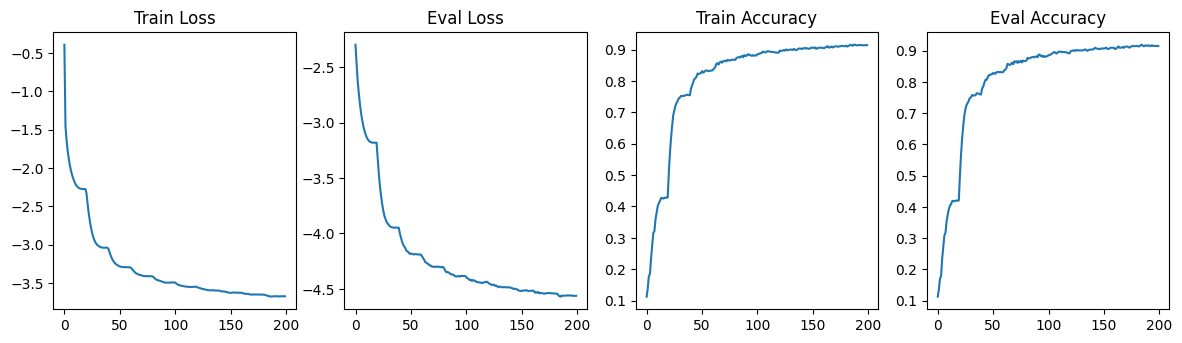

In [250]:
train(model, optimizer, scheduler, EPOCHS, TRAIN_BATCH_SIZE);

# Evaluate model

Accuracy

In [251]:
get_accuracy(model, train_inp, train_out, 0.5, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.5, EVAL_BATCH_SIZE)

(0.9981, 0.9989)

In [252]:
get_accuracy(model, train_inp, train_out, 0.1, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.1, EVAL_BATCH_SIZE)

(0.9908, 0.9926)

In [253]:
get_accuracy(model, train_inp, train_out, 0.03, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.03, EVAL_BATCH_SIZE)

(0.9133, 0.9163)

Training data

In [254]:
test_inp, test_out = sample_batch(train_inp, train_out, n=3)

In [255]:
torch.round(test_inp[:, -10:].to(torch.float64) / MULTIPLIER, decimals=0)

tensor([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]], device='cuda:0',
       dtype=torch.float64)

In [256]:
torch.round(test_out[:, -10:].to(torch.float64) / MULTIPLIER, decimals=0)

tensor([[195., 196., 197., 198., 199., 200., 202., 202., 203., 205.],
        [111., 112., 113., 114., 115., 116., 117., 118., 119., 120.],
        [160., 161., 162., 163., 164., 165., 166., 167., 168., 169.]],
       device='cuda:0', dtype=torch.float64)

In [257]:
with torch.no_grad():
    test_pred = model(test_inp)
torch.round(test_pred[:, -10:].to(torch.float64) / MULTIPLIER, decimals=0)

tensor([[196., 197., 198., 198., 199., 200., 200., 199., 198., 198.],
        [110., 111., 111., 112., 113., 114., 115., 116., 115., 116.],
        [158., 161., 162., 164., 164., 166., 167., 169., 170., 171.]],
       device='cuda:0', dtype=torch.float64)

Evaluation data

In [258]:
test_inp, test_out = sample_batch(train_inp, train_out, n=4)

In [259]:
torch.round(test_inp[:, -10:].to(torch.float64) / MULTIPLIER, decimals=0)

tensor([[136., 137.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.]],
       device='cuda:0', dtype=torch.float64)

In [260]:
torch.round(test_out[:, -10:].to(torch.float64) / MULTIPLIER, decimals=0)

tensor([[142., 143., 144., 145., 146., 147., 148., 149., 150., 151.],
        [205., 205., 206., 206., 208., 209., 209., 211., 212., 212.],
        [216., 217., 219., 219., 220., 220., 222., 223., 223., 225.],
        [219., 220., 220., 222., 223., 223., 225., 227., 227., 228.]],
       device='cuda:0', dtype=torch.float64)

In [261]:
with torch.no_grad():
    test_pred = model(test_inp)
torch.round(test_pred[:, -10:].to(torch.float64) / MULTIPLIER, decimals=0)

tensor([[142., 144., 144., 145., 145., 144., 145., 146., 148., 149.],
        [205., 206., 206., 206., 208., 209., 211., 211., 212., 212.],
        [214., 217., 217., 217., 219., 220., 222., 222., 223., 225.],
        [219., 220., 222., 222., 222., 223., 225., 225., 225., 227.]],
       device='cuda:0', dtype=torch.float64)

In [262]:
with torch.no_grad():
    test_position = model(test_inp, single=True)
torch.round(test_position.to(torch.float64) / MULTIPLIER, decimals=0)

tensor([150., 212., 225., 227.], device='cuda:0', dtype=torch.float64)

In [263]:
with torch.no_grad():
    test_position = model(test_inp, pos_idx=-1)
torch.round(test_position[:, -10:].to(torch.float64) / MULTIPLIER, decimals=0)

tensor([[142., 144., 144., 145., 145., 144., 145., 146., 148., 149.],
        [205., 206., 206., 206., 208., 209., 211., 211., 212., 212.],
        [214., 217., 217., 217., 219., 220., 222., 222., 223., 225.],
        [219., 220., 222., 222., 222., 223., 225., 225., 225., 227.]],
       device='cuda:0', dtype=torch.float64)

In [276]:
def plot_attention(inputs: Tensor, layer_index: int | None = None, size=(1440, 1080), inverse=False,
                   cmap='bone_r', crop=1, exg=1, single=False, force_line=False):
    assert inputs.ndim == 1
    plt.close()

    # Calculate attention
    with torch.no_grad():
        model(inputs, get=True, single=single)
        tx_base = model.transformer

    # Get layers self attention
    self_attention = [l[0].to('cpu', torch.float) for l in tx_base.get_attention()]
    if layer_index is not None:
        self_attention = self_attention[[layer_index]]
    # if layer_index is not None:
    #     self_attention = self_attention[layer_index].to('cpu', torch.float64)
    # else:
    #     self_attention = torch.mean(torch.stack(self_attention), dim=0).to('cpu', torch.float64)
    b, heads, q, k = self_attention[0].shape
    columns = heads
    rows = len(self_attention) if layer_index is None else 1
    fig, axes = plt.subplots(rows, columns, figsize=(size[0] * 0.01, size[1] * 0.01))
    # fig.patch.set_facecolor(bg)
    print(axes.shape)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    if inverse:
        axes = axes[::-1]
    x = 0
    for li, attention in enumerate(self_attention):
        for hi, att_head in enumerate(attention[0]):
            if force_line:
                att_head = att_head[[-1]]
            q, k = att_head.shape[-2:]
            # print(q, k)
            title = f"L{li if layer_index is None else layer_index} H{hi}"
            if q != 1:
                # att_head = att_head.expand(k, k)
                # q = k
                if exg is not None:
                    att_head = torch.clamp(att_head * exg, 0, 1)
                if crop is not None:
                    k_red = k // crop
                    k_max = max(1, k // 2 - k_red)
                    k_idx = np.random.randint(k_max)
                    k_ind = torch.arange(k_idx, k_idx + k_red).to(att_head.device)
                    q_red = min(q, q // crop)
                    q_max = max(1, q // 2 - q_red)
                    q_idx = np.random.randint(q_max)
                    q_ind = torch.arange(q_idx, q_idx + q_red).to(att_head.device)
                    # print(q_ind, k_ind, att_head.shape)
                    # print(att_head.shape, q_ind.shape, k_ind.shape, q, k)
                    att_head = torch.index_select(torch.index_select(att_head, 0, q_ind), 1, k_ind)
                    # print(att_head.shape)
                axes[x].imshow(att_head.float().cpu(), cmap=cmap)
            else:
                axes[x].plot(att_head.squeeze(0))
            axes[x].set_title(title)
            x += 1
    plt.show()

torch.Size([100]) 30
(3, 4)


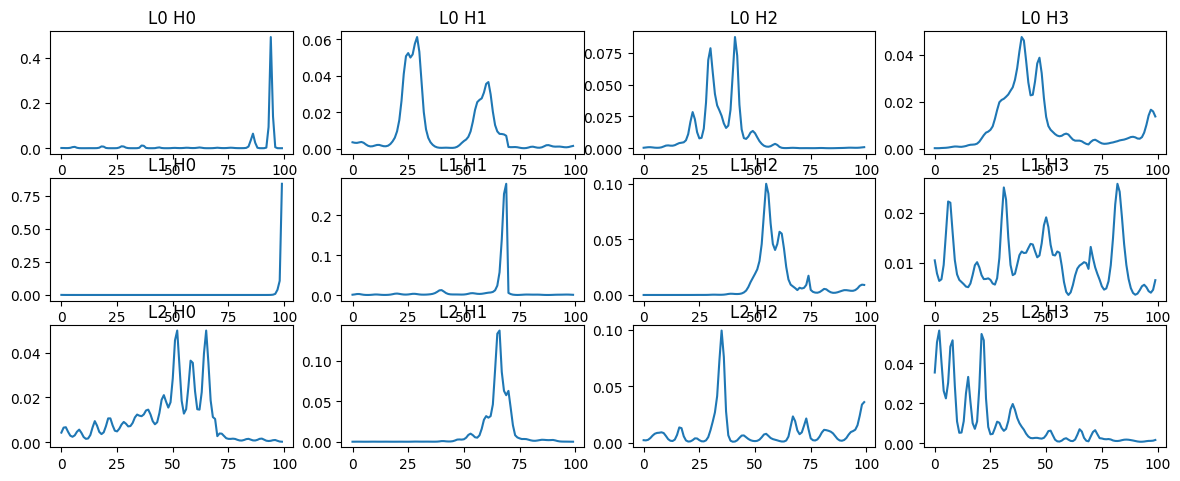

In [294]:
sample_input = sample_batch(eval_inp, n=1)[0][0]
missing_count = torch.count_nonzero(torch.round(sample_input.to(torch.float) / MULTIPLIER) == -1).cpu().item()
print(sample_input.shape, missing_count)
plot_attention(sample_input, layer_index=None, size=(1440, 540), crop=1, exg=3, single=True, force_line=True)

torch.Size([100]) 14
(3, 4)


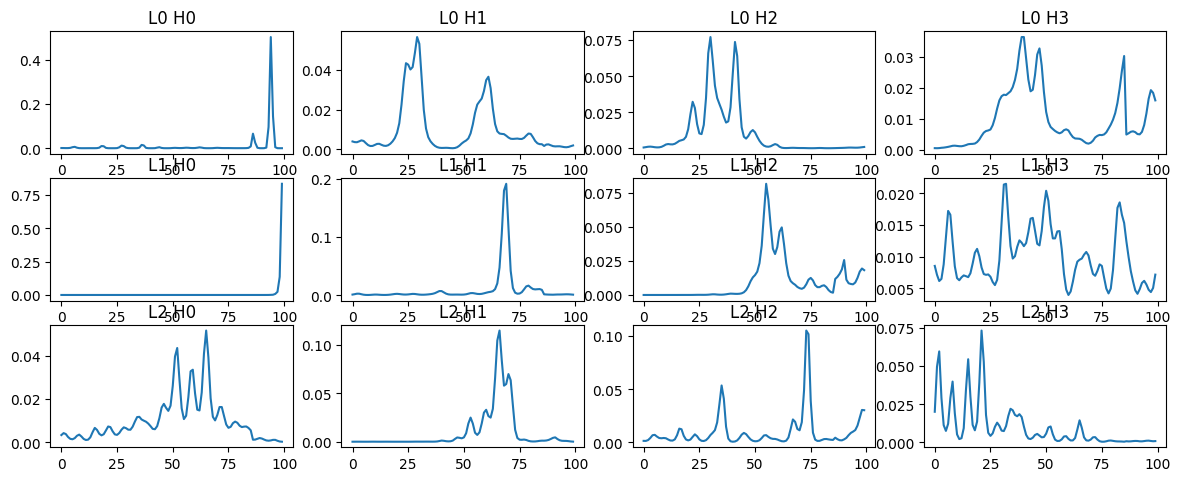

In [297]:
sample_input = sample_batch(eval_inp, n=1)[0][0]
missing_count = torch.count_nonzero(torch.round(sample_input.to(torch.float) / MULTIPLIER) == -1).cpu().item()
print(sample_input.shape, missing_count)
plot_attention(sample_input, layer_index=None, size=(1440, 540), crop=1, exg=3, single=False, force_line=True)